In [1]:
import os
import heapq
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import joblib
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from sklearn.linear_model import QuantileRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from qcportal import PortalClient

In [2]:
def calculate_total_time(time_secs: list[float], cpu_counts: list[int],
                         max_cpus: int = 3000, sort: str = 'cpu_desc') -> float:
    """
    Calculate the total wall-clock time required to run all tasks given a
    global CPU cap (max_cpus). Tasks are non-preemptive. The scheduler is
    event-driven (min-heap of finishing tasks) and runs in O(n log n).

    Args:
        time_secs: list of task durations in seconds
        cpu_counts: list of CPU requirements for each task
        max_cpus: global number of CPUs available at any moment
        sort: ordering strategy for tasks before scheduling. Options:
              'cpu_desc' (default) - schedule largest CPU tasks first
              'cpu_time_desc' - schedule by cpu * duration desc
              'none' - keep input order

    Returns:
        total_time_seconds: float, wall-clock time until all tasks complete
    """
    if len(time_secs) != len(cpu_counts):
        raise ValueError("time_secs and cpu_counts must have same length")

    n = len(time_secs)
    # Build tasks as (cpu, duration)
    tasks = [(int(cpu_counts[i]), float(time_secs[i])) for i in range(n)]

    if any(cpu > max_cpus for cpu, _ in tasks):
        raise ValueError("At least one task requires more CPUs than available (max_cpus).")

    if sort == 'cpu_desc':
        tasks.sort(key=lambda x: (-x[0], -x[0]*x[1]))
    elif sort == 'cpu_time_desc':
        tasks.sort(key=lambda x: -(x[0] * x[1]))
    elif sort == 'none':
        pass
    else:
        raise ValueError(f"Unknown sort option: {sort}")

    # Event-driven scheduling
    running = []  # min-heap of (end_time, cpu_req)
    current_time = 0.0
    total_used_cpus = 0

    for cpu_req, duration in tasks:
        # Free up CPUs until we can schedule this task
        while total_used_cpus + cpu_req > max_cpus:
            if not running:
                # Should not happen because we checked cpu_req <= max_cpus
                raise RuntimeError("No running tasks to free CPUs, stuck")
            end_time, cpu_freed = heapq.heappop(running)
            current_time = max(current_time, end_time)
            total_used_cpus -= cpu_freed

        # Schedule task at current_time
        heapq.heappush(running, (current_time + duration, cpu_req))
        total_used_cpus += cpu_req

    # All tasks scheduled; completion is the latest end_time in the heap
    total_time = 0.0
    while running:
        end_time, _ = heapq.heappop(running)
        total_time = max(total_time, end_time)

    return float(total_time)


def lower_bound_time_from_cpu(time_secs: list[float], cpu_counts: list[int], max_cpus: int) -> float:
    """
    Compute a theoretical lower bound on wall-clock time: sum(cpu_i * t_i) / max_cpus
    """
    total_cpu_seconds = sum(int(c) * float(t) for c, t in zip(cpu_counts, time_secs))
    return total_cpu_seconds / float(max_cpus)


# Quick example / test
if __name__ == "__main__":
    # Small synthetic workload
    durations = [3600, 7200, 1800, 5400]  # seconds
    cpus = [100, 200, 50, 150]
    max_cpus = 300

    print("Lower bound time (s):", lower_bound_time_from_cpu(durations, cpus, max_cpus))
    print("Simulated total time (s):", calculate_total_time(durations, cpus, max_cpus))
    print("Simulated total time (hours):", calculate_total_time(durations, cpus, max_cpus)/3600.0)


Lower bound time (s): 9000.0
Simulated total time (s): 12600.0
Simulated total time (hours): 3.5


## Assess Wall Time v.s. Molecular Weight

In [3]:
ADDRESS = "https://api.qcarchive.molssi.org:443/"
#qc_client = PortalClient(ADDRESS, cache_dir=".")
qc_client = PortalClient(
    ADDRESS, 
#    username=os.environ['QCARCHIVE_USER'],
#    password=os.environ['QCARCHIVE_PASSWORD'],
    cache_dir=".",
)

dataset_type = "singlepoint"
dataset_names = [
    "Curated tmQM-xtb Dataset: T=100K Dataset Restricted to Pd, Zn, Fe, Cu v0.0",
#    "tmQM xtb Dataset T=100K low-mw high-coordinate mult=1 v0.0",
#    "tmQM xtb Dataset T=100K low-mw high-coordinate mult=3 v0.0",
#    "tmQM xtb Dataset T=100K low-mw high-coordinate mult=5 v0.0",
]

In [4]:
output = defaultdict()
for ds_name in [dataset_names[0]]:
    filename = f"molecular_weight_walltime/MW_Walltime_{ds_name.replace(' ', '-')}.csv"
    if os.path.isfile(filename):
        output[ds_name] = np.genfromtxt(
            filename,
            delimiter=",",
        )
    else:
        print(f"Loading {ds_name}")
        ds = qc_client.get_dataset(dataset_type, ds_name)
        print(ds.specification_names)
        print(f"Fetching records...")
        ds.fetch_records()
        print(f"Evaluating records...")
        def process_record(rec_tuple):
            _, _, rec = next(rec_tuple)
            return [
                int(rec.molecule.extras["molecular_weight"]),
                int(rec.compute_history[-1].provenance.wall_time),
                int(rec.molecule.molecular_multiplicity),
            ]
        rec_generator = ds.iterate_records(status="complete")
        total = ds.record_count

        tmp = []
        if total == 0:
            print("No completed records found.")
        else:
            last_printed = -1
            # process records lazily; do not build a full list in memory
            with ThreadPoolExecutor(max_workers=1) as executor:
                for i, result in enumerate(executor.map(process_record, rec_generator), start=1):
                    tmp.append(result)
                    pct = (i * 100) // total
                    if pct % 5 == 0 and pct != last_printed:
                        print(f"Progress: {pct}% ({i}/{total} records)")
                        last_printed = pct
                    if i % 1000 == 0:
                        print(f"Processed {i} records...")

        if tmp:
            arr = np.array(tmp)
            plt.plot(arr[:, 0], arr[:, 1])
            output[ds_name] = arr
            np.savetxt(
                filename,
                arr.T,
                delimiter=",",
                header="#Molecular Weight, Wall Time, Multiplicity"
            )
        else:
            print(f"No data to save for dataset: {ds_name}")
plt.show()

Loading Curated tmQM-xtb Dataset: T=100K Dataset Restricted to Pd, Zn, Fe, Cu v0.0
['BP86/def2-TZVP']
Fetching records...


KeyboardInterrupt: 

In [ ]:
np.shape(output[ds_name])

(2, 528302)

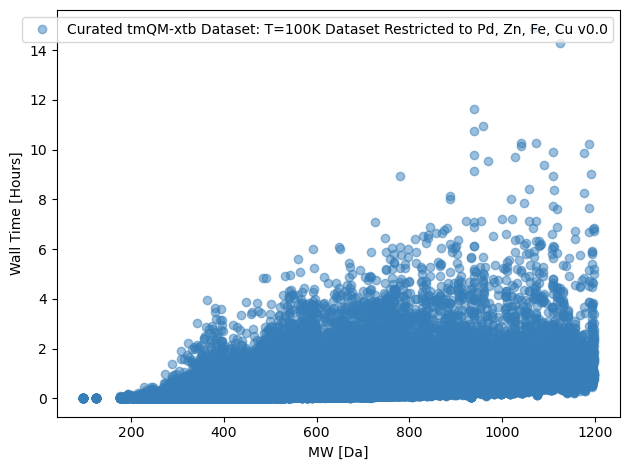

In [ ]:
markers = ["o", "s", "d", "^"]
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

all_data = {1: [], 3: [], 5: []}
for i, (ds_name, data) in enumerate(output.items()):
    data = data[np.where(data[0] < 1200)]
    all_data[1] = data[np.where(data[2] == 1)]
    all_data[3] = data[np.where(data[2] == 3)]
    all_data[5] = data[np.where(data[2] == 5)]
    plt.plot(all_data[1][0], all_data[1][1]/3600, linestyle="None", marker=markers[i], alpha=0.5, label="1:"+ds_name, color=CB_color_cycle[i])
    plt.plot(all_data[3][0], all_data[3][1]/3600, linestyle="None", marker=markers[i], alpha=0.5, label="3:"+ds_name, color=CB_color_cycle[i])
    plt.plot(all_data[5][0], all_data[5][1]/3600, linestyle="None", marker=markers[i], alpha=0.5, label="5:"+ds_name, color=CB_color_cycle[i])

plt.xlabel("MW [Da]")
plt.ylabel("Wall Time [Hours]")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [ ]:
def quantile_models(xdata, ydata, path=None, extension=""):
    
    xdata = np.array(xdata)
    ydata = np.array(ydata)
    X = xdata.reshape(-1, 1)
    qr50 = QuantileRegressor(quantile=0.5, alpha=0).fit(X, ydata)
    print("Fit qr50")
    qr90 = QuantileRegressor(quantile=0.90, alpha=0).fit(X, ydata)
    print("Fit qr90")
    qr99 = QuantileRegressor(quantile=0.99, alpha=0).fit(X, ydata)
    print("Fit qr99")
    
    if path is not None:
        os.makedirs(path, exist_ok=True)
    else:
        path = "."
    joblib.dump(qr50, os.path.join(path, f"qr50_model{extension}.pkl"))
    joblib.dump(qr90, os.path.join(path, f"qr90_model{extension}.pkl"))
    joblib.dump(qr99, os.path.join(path, f"qr99_model{extension}.pkl"))
    
    return qr50.predict(X), qr90.predict(X), qr99.predict(X)


In [ ]:
def heteroscedastic_regression(xdata, ydata, path=None):
    
    xdata = np.array(xdata)
    ydata = np.array(ydata)
    X = xdata.reshape(-1, 1)
    kernel = 1.0 * RBF(length_scale=2.0) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 10))
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
    gpr.fit(X, ydata)
    print("Fit gpr")

    if path is not None:
        os.makedirs(path, exist_ok=True)
    else:
        path = "."
    joblib.dump(gpr, os.path.join(path, "gaussian_process_regression_model.pkl"))
    
    t_mean, t_std = gpr.predict(X, return_std=True)
    return t_mean, t_std

In [ ]:
if os.path.isfile("models/qr50_model.pkl"):
    X = np.array(all_data[0]).reshape(-1, 1)
    qr50 = joblib.load("models/qr50_model.pkl")
    qr90 = joblib.load("models/qr90_model.pkl")
    qr99 = joblib.load("models/qr99_model.pkl")
    t_pred_50 = np.array([x if x > 0 else 60 for x in qr50.predict(X)])
    t_pred_90 = np.array([x if x > 0 else 60 for x in qr90.predict(X)])
    t_pred_99 = np.array([x if x > 0 else 60 for x in qr99.predict(X)])
    print([np.shape(x) for x in [all_data[0], t_pred_50, t_pred_90, t_pred_99]])
else:
    t_pred_50_1, t_pred_90_1, t_pred_99_1 = quantile_models(all_data[1][0], all_data[1][1], path="models", extension="_1")
    t_pred_50_3, t_pred_90_3, t_pred_99_3 = quantile_models(all_data[3][0], all_data[3][1], path="models", extension="_3")
    t_pred_50_5, t_pred_90_5, t_pred_99_5 = quantile_models(all_data[5][0], all_data[5][1], path="models", extension="_5")
#    t_mean, t_std = heteroscedastic_regression(all_data[0], all_data[1], path="models")

[(528017,), (528017,), (528017,), (528017,)]


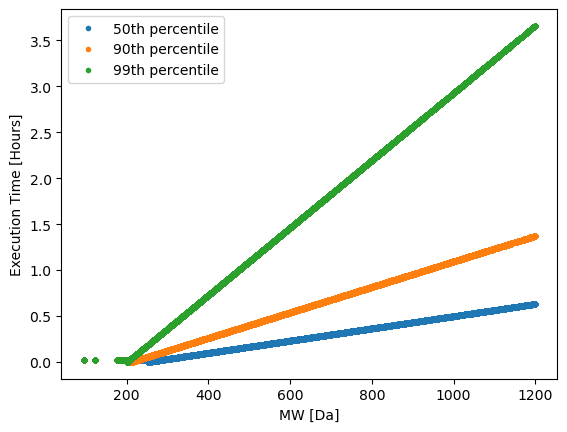

In [ ]:
plt.plot(all_data[1][0], t_pred_50_1/3600, label="M1 50th percentile", linestyle="-")
plt.plot(all_data[1][0], t_pred_90_1/3600, label="M1 90th percentile", linestyle="-")
plt.plot(all_data[1][0], t_pred_99_1/3600, label="M1 99th percentile", linestyle="-")

plt.plot(all_data[3][0], t_pred_50_3/3600, label="M3 50th percentile", linestyle="--")
plt.plot(all_data[3][0], t_pred_90_3/3600, label="M3 90th percentile", linestyle="--")
plt.plot(all_data[3][0], t_pred_99_3/3600, label="M3 99th percentile", linestyle="--")

plt.plot(all_data[5][0], t_pred_50_5/3600, label="M5 50th percentile", linestyle=":")
plt.plot(all_data[5][0], t_pred_90_5/3600, label="M5 90th percentile", linestyle=":")
plt.plot(all_data[5][0], t_pred_99_5/3600, label="M5 99th percentile", linestyle=":")
plt.legend(loc="best")
plt.xlabel("MW [Da]")
plt.ylabel("Execution Time [Hours]")
plt.show()

## Import Dataset

In [ ]:
n_replicates = 10

Total time to compute dataset in days: 50 percentile 2.376196434034107
Total time to compute dataset in days: 90 percentile 8.367202365716523
Total time to compute dataset in days: 99 percentile 24.44316627615248


Text(0, 0.5, 'Count')

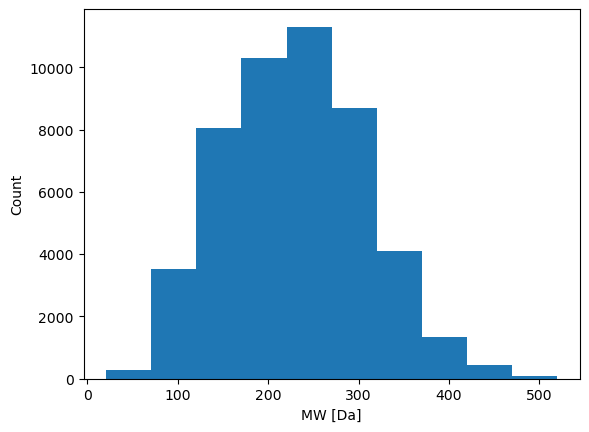

In [ ]:
df = pd.read_csv("../2_generate_subset/a_subset1/selected_design.csv")
molecular_weight = df["MW"].to_numpy().reshape(-1, 1)
cpu_counts = np.select(
    [
        molecular_weight.flatten() < 200,
        molecular_weight.flatten() < 250,
        molecular_weight.flatten() < 300,
        molecular_weight.flatten() < 350,
        molecular_weight.flatten() < 400,
        molecular_weight.flatten() < 450,
        molecular_weight.flatten() < 500,
        molecular_weight.flatten() < 550,
        molecular_weight.flatten() < 600,
    ],
    [3, 4, 20, 20, 32, 32, 34, 50, 65],
    default=32
)
t_50_mw = qr50.predict(molecular_weight)
t_90_mw = qr90.predict(molecular_weight)
t_99_mw = qr99.predict(molecular_weight)
print(
    "Total time to compute dataset in days: 50 percentile", 
    calculate_total_time(t_50_mw, cpu_counts, max_cpus=3000) * n_replicates / 3600 / 24
)
print(
    "Total time to compute dataset in days: 90 percentile", 
    calculate_total_time(t_90_mw, cpu_counts, max_cpus=3000) * n_replicates / 3600 / 24
)
print(
    "Total time to compute dataset in days: 99 percentile", 
    calculate_total_time(t_99_mw, cpu_counts, max_cpus=3000) * n_replicates / 3600 / 24
)
plt.hist(molecular_weight)
plt.xlabel("MW [Da]")
plt.ylabel("Count")

### 200k * 10 = 2 million


Total time to compute dataset in days: 50 percentile 9.195679570377708
Total time to compute dataset in days: 90 percentile 32.7171052197239
Total time to compute dataset in days: 99 percentile 95.72423068610402
Total time to compute dataset in days: 99 percentile 95.72423068610402


Text(0, 0.5, 'Count')

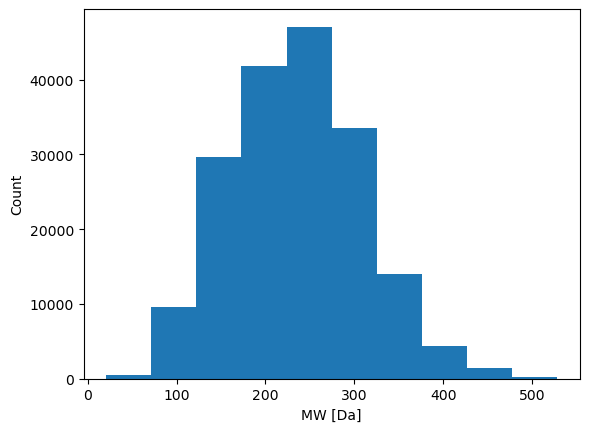

In [ ]:
df = pd.read_csv("../2_generate_subset/a_subset2/selected_design.csv")
molecular_weight = df["MW"].to_numpy().reshape(-1, 1)
cpu_counts = np.select(
    [
        molecular_weight.flatten() < 200,
        molecular_weight.flatten() < 250,
        molecular_weight.flatten() < 300,
        molecular_weight.flatten() < 350,
        molecular_weight.flatten() < 400,
        molecular_weight.flatten() < 450,
        molecular_weight.flatten() < 500,
        molecular_weight.flatten() < 550,
        molecular_weight.flatten() < 600,
    ],
    [3, 4, 20, 20, 32, 32, 34, 50, 65],
    default=32
)
t_50_mw = qr50.predict(molecular_weight)
t_90_mw = qr90.predict(molecular_weight)
t_99_mw = qr99.predict(molecular_weight)
print(
    "Total time to compute dataset in days: 50 percentile", 
    calculate_total_time(t_50_mw, cpu_counts, max_cpus=3000) * n_replicates / 3600 / 24
)
print(
    "Total time to compute dataset in days: 90 percentile", 
    calculate_total_time(t_90_mw, cpu_counts, max_cpus=3000) * n_replicates / 3600 / 24
)
print(
    "Total time to compute dataset in days: 99 percentile", 
    calculate_total_time(t_99_mw, cpu_counts, max_cpus=3000) * n_replicates / 3600 / 24
)
plt.hist(molecular_weight)
plt.xlabel("MW [Da]")
plt.ylabel("Count")